In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:32 - loss: 0.2765 - STD: 1.5404e-04 - MAE: 0.5168

 4/74 [>.............................] - ETA: 1s - loss: 0.0977 - STD: 4.1621e-04 - MAE: 0.2453  

 5/74 [=>............................] - ETA: 2s - loss: 0.0817 - STD: 3.6445e-04 - MAE: 0.2162

 6/74 [=>............................] - ETA: 2s - loss: 0.0719 - STD: 3.1736e-04 - MAE: 0.2001

 7/74 [=>............................] - ETA: 8s - loss: 0.0689 - STD: 2.7854e-04 - MAE: 0.1906

11/74 [===>..........................] - ETA: 5s - loss: 0.0546 - STD: 1.8186e-04 - MAE: 0.1756

12/74 [===>..........................] - ETA: 5s - loss: 0.0527 - STD: 1.6707e-04 - MAE: 0.1738

13/74 [====>.........................] - ETA: 4s - loss: 0.0510 - STD: 1.5473e-04 - MAE: 0.1722

14/74 [====>.........................] - ETA: 4s - loss: 0.0497 - STD: 1.4436e-04 - MAE: 0.1709

15/74 [=====>........................] - ETA: 4s - loss: 0.0484 - STD: 1.3555e-04 - MAE: 0.1696

16/74 [=====>........................] - ETA: 4s - loss: 0.0473 - STD: 1.2796e-04 - MAE: 0.1682

17/74 [=====>........................] - ETA: 4s - loss: 0.0462 - STD: 1.2140e-04 - MAE: 0.1668

18/74 [======>.......................] - ETA: 4s - loss: 0.0452 - STD: 1.1571e-04 - MAE: 0.1654

19/74 [======>.......................] - ETA: 4s - loss: 0.0443 - STD: 1.1063e-04 - MAE: 0.1640

20/74 [=======>......................] - ETA: 3s - loss: 0.0434 - STD: 1.0622e-04 - MAE: 0.1625

21/74 [=======>......................] - ETA: 3s - loss: 0.0425 - STD: 1.0230e-04 - MAE: 0.1607

22/74 [=======>......................] - ETA: 3s - loss: 0.0415 - STD: 9.8814e-05 - MAE: 0.1588

23/74 [========>.....................] - ETA: 3s - loss: 0.0406 - STD: 9.5707e-05 - MAE: 0.1567

24/74 [========>.....................] - ETA: 3s - loss: 0.0397 - STD: 9.2918e-05 - MAE: 0.1545

25/74 [=========>....................] - ETA: 3s - loss: 0.0387 - STD: 9.0548e-05 - MAE: 0.1520

26/74 [=========>....................] - ETA: 3s - loss: 0.0377 - STD: 8.8357e-05 - MAE: 0.1495

27/74 [=========>....................] - ETA: 3s - loss: 0.0367 - STD: 8.6377e-05 - MAE: 0.1469

28/74 [==========>...................] - ETA: 3s - loss: 0.0358 - STD: 8.4547e-05 - MAE: 0.1443

29/74 [==========>...................] - ETA: 3s - loss: 0.0349 - STD: 8.2688e-05 - MAE: 0.1419

30/74 [===========>..................] - ETA: 3s - loss: 0.0340 - STD: 8.1137e-05 - MAE: 0.1397

31/74 [===========>..................] - ETA: 2s - loss: 0.0332 - STD: 7.9647e-05 - MAE: 0.1378

32/74 [===========>..................] - ETA: 2s - loss: 0.0325 - STD: 7.8331e-05 - MAE: 0.1361

33/74 [============>.................] - ETA: 2s - loss: 0.0318 - STD: 7.7007e-05 - MAE: 0.1347

34/74 [============>.................] - ETA: 2s - loss: 0.0312 - STD: 7.5659e-05 - MAE: 0.1335

35/74 [=============>................] - ETA: 2s - loss: 0.0307 - STD: 7.4311e-05 - MAE: 0.1324

36/74 [=============>................] - ETA: 2s - loss: 0.0302 - STD: 7.3075e-05 - MAE: 0.1314

37/74 [==============>...............] - ETA: 2s - loss: 0.0297 - STD: 7.1778e-05 - MAE: 0.1303

38/74 [==============>...............] - ETA: 2s - loss: 0.0292 - STD: 7.0575e-05 - MAE: 0.1292

39/74 [==============>...............] - ETA: 2s - loss: 0.0287 - STD: 6.9482e-05 - MAE: 0.1281

40/74 [===============>..............] - ETA: 2s - loss: 0.0282 - STD: 6.8243e-05 - MAE: 0.1270

41/74 [===============>..............] - ETA: 2s - loss: 0.0277 - STD: 6.7045e-05 - MAE: 0.1258

42/74 [================>.............] - ETA: 2s - loss: 0.0273 - STD: 6.5891e-05 - MAE: 0.1246

43/74 [================>.............] - ETA: 2s - loss: 0.0269 - STD: 6.4665e-05 - MAE: 0.1234

44/74 [================>.............] - ETA: 1s - loss: 0.0265 - STD: 6.3558e-05 - MAE: 0.1223

45/74 [=================>............] - ETA: 1s - loss: 0.0261 - STD: 6.2466e-05 - MAE: 0.1212

46/74 [=================>............] - ETA: 1s - loss: 0.0257 - STD: 6.1391e-05 - MAE: 0.1202

47/74 [==================>...........] - ETA: 1s - loss: 0.0254 - STD: 6.0316e-05 - MAE: 0.1192

48/74 [==================>...........] - ETA: 1s - loss: 0.0250 - STD: 5.9250e-05 - MAE: 0.1183

49/74 [==================>...........] - ETA: 1s - loss: 0.0247 - STD: 5.8270e-05 - MAE: 0.1174

50/74 [===================>..........] - ETA: 1s - loss: 0.0244 - STD: 5.7288e-05 - MAE: 0.1165

51/74 [===================>..........] - ETA: 1s - loss: 0.0241 - STD: 5.6326e-05 - MAE: 0.1157

52/74 [====================>.........] - ETA: 1s - loss: 0.0239 - STD: 5.5418e-05 - MAE: 0.1149

53/74 [====================>.........] - ETA: 1s - loss: 0.0236 - STD: 5.4546e-05 - MAE: 0.1141

54/74 [====================>.........] - ETA: 1s - loss: 0.0233 - STD: 5.3722e-05 - MAE: 0.1134

55/74 [=====================>........] - ETA: 1s - loss: 0.0231 - STD: 5.2939e-05 - MAE: 0.1127

56/74 [=====================>........] - ETA: 1s - loss: 0.0228 - STD: 5.2206e-05 - MAE: 0.1120

57/74 [======================>.......] - ETA: 1s - loss: 0.0226 - STD: 5.1451e-05 - MAE: 0.1114

58/74 [======================>.......] - ETA: 1s - loss: 0.0224 - STD: 5.0752e-05 - MAE: 0.1108

59/74 [======================>.......] - ETA: 0s - loss: 0.0221 - STD: 5.0061e-05 - MAE: 0.1102

60/74 [=======================>......] - ETA: 0s - loss: 0.0219 - STD: 4.9385e-05 - MAE: 0.1096

61/74 [=======================>......] - ETA: 0s - loss: 0.0217 - STD: 4.8716e-05 - MAE: 0.1091

62/74 [========================>.....] - ETA: 0s - loss: 0.0215 - STD: 4.8110e-05 - MAE: 0.1086

63/74 [========================>.....] - ETA: 0s - loss: 0.0213 - STD: 4.7520e-05 - MAE: 0.1081

64/74 [========================>.....] - ETA: 0s - loss: 0.0211 - STD: 4.6924e-05 - MAE: 0.1077

65/74 [=========================>....] - ETA: 0s - loss: 0.0209 - STD: 4.6331e-05 - MAE: 0.1072

66/74 [=========================>....] - ETA: 0s - loss: 0.0208 - STD: 4.5785e-05 - MAE: 0.1068

67/74 [==========================>...] - ETA: 0s - loss: 0.0206 - STD: 4.5269e-05 - MAE: 0.1063

68/74 [==========================>...] - ETA: 0s - loss: 0.0204 - STD: 4.4769e-05 - MAE: 0.1059

69/74 [==========================>...] - ETA: 0s - loss: 0.0203 - STD: 4.4260e-05 - MAE: 0.1054

70/74 [===========================>..] - ETA: 0s - loss: 0.0201 - STD: 4.3750e-05 - MAE: 0.1050

71/74 [===========================>..] - ETA: 0s - loss: 0.0199 - STD: 4.3263e-05 - MAE: 0.1046

72/74 [============================>.] - ETA: 0s - loss: 0.0198 - STD: 4.2786e-05 - MAE: 0.1042

73/74 [============================>.] - ETA: 0s - loss: 0.0197 - STD: 4.2324e-05 - MAE: 0.1038

74/74 [==============================] - ETA: 0s - loss: 0.0195 - STD: 4.1884e-05 - MAE: 0.1034

74/74 [==============================] - 6s 72ms/step - loss: 0.0195 - STD: 4.1884e-05 - MAE: 0.1034 - val_loss: 0.0086 - val_STD: 8.8625e-06 - val_MAE: 0.0709


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0093 - STD: 1.0290e-05 - MAE: 0.0743

 2/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 9.9273e-06 - MAE: 0.0741

 3/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 9.7709e-06 - MAE: 0.0741

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 9.5480e-06 - MAE: 0.0743

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 9.3156e-06 - MAE: 0.0749

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 9.2584e-06 - MAE: 0.0749

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 9.3468e-06 - MAE: 0.0751

 8/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 9.2811e-06 - MAE: 0.0750

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 9.2156e-06 - MAE: 0.0749

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 9.2681e-06 - MAE: 0.0750

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 9.5576e-06 - MAE: 0.0751

12/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 9.6144e-06 - MAE: 0.0752

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 9.6083e-06 - MAE: 0.0752

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 9.6207e-06 - MAE: 0.0752

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 9.5719e-06 - MAE: 0.0753

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 9.6837e-06 - MAE: 0.0753

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 9.7541e-06 - MAE: 0.0753

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 9.6461e-06 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 9.5971e-06 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 9.5761e-06 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 9.5551e-06 - MAE: 0.0753

23/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 9.5621e-06 - MAE: 0.0752

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 9.5315e-06 - MAE: 0.0752

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 9.5170e-06 - MAE: 0.0752

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 9.5038e-06 - MAE: 0.0752

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 9.4758e-06 - MAE: 0.0752

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 9.5109e-06 - MAE: 0.0752

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 9.5293e-06 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 9.5181e-06 - MAE: 0.0752

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 9.5234e-06 - MAE: 0.0752

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 9.5468e-06 - MAE: 0.0752

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 9.5890e-06 - MAE: 0.0752

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 9.5836e-06 - MAE: 0.0753

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 9.6031e-06 - MAE: 0.0753

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 9.6055e-06 - MAE: 0.0753

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.5872e-06 - MAE: 0.0753

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.5808e-06 - MAE: 0.0753

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.5689e-06 - MAE: 0.0753

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 9.5652e-06 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 9.5881e-06 - MAE: 0.0753

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 9.5934e-06 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 9.6418e-06 - MAE: 0.0753

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 9.6305e-06 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 9.6298e-06 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 9.6654e-06 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 9.6813e-06 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 9.7033e-06 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 9.7414e-06 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 9.7734e-06 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 9.7855e-06 - MAE: 0.0753

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 9.7815e-06 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 9.7816e-06 - MAE: 0.0753

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 9.7914e-06 - MAE: 0.0753

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 9.8053e-06 - MAE: 0.0753

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 9.8304e-06 - MAE: 0.0753

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.8508e-06 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.8633e-06 - MAE: 0.0753

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.8838e-06 - MAE: 0.0753

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.9009e-06 - MAE: 0.0753

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.9335e-06 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.9754e-06 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0023e-05 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0074e-05 - MAE: 0.0753

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0126e-05 - MAE: 0.0753

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0178e-05 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0231e-05 - MAE: 0.0753

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0278e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0328e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.0392e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.0464e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.0545e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.0635e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.0731e-05 - MAE: 0.0754

74/74 [==============================] - 5s 62ms/step - loss: 0.0092 - STD: 1.0731e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.3377e-05 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0093 - STD: 1.8289e-05 - MAE: 0.0756

 2/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 1.8272e-05 - MAE: 0.0755

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.8078e-05 - MAE: 0.0751

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.7733e-05 - MAE: 0.0751

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.7445e-05 - MAE: 0.0751

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.7289e-05 - MAE: 0.0752

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 1.7231e-05 - MAE: 0.0754

 8/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.7283e-05 - MAE: 0.0754

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 1.7395e-05 - MAE: 0.0753

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.7482e-05 - MAE: 0.0753

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.7554e-05 - MAE: 0.0753

12/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.7599e-05 - MAE: 0.0753

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.7533e-05 - MAE: 0.0753

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.7455e-05 - MAE: 0.0753

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.7383e-05 - MAE: 0.0753

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.7314e-05 - MAE: 0.0753

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.7252e-05 - MAE: 0.0752

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.7250e-05 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.7248e-05 - MAE: 0.0753

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.7275e-05 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.7333e-05 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.7396e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.7440e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 1.7502e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.7652e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.7799e-05 - MAE: 0.0755

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.7913e-05 - MAE: 0.0755

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.8048e-05 - MAE: 0.0755

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.8204e-05 - MAE: 0.0755

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.8356e-05 - MAE: 0.0755

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.8518e-05 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.8687e-05 - MAE: 0.0755

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.8842e-05 - MAE: 0.0755

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.8992e-05 - MAE: 0.0755

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.9126e-05 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.9266e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9413e-05 - MAE: 0.0755

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9569e-05 - MAE: 0.0755

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9772e-05 - MAE: 0.0755

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.9971e-05 - MAE: 0.0755

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.0143e-05 - MAE: 0.0755

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.0272e-05 - MAE: 0.0755

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.0401e-05 - MAE: 0.0755

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.0525e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.0662e-05 - MAE: 0.0755

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.0821e-05 - MAE: 0.0755

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.0989e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.1186e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.1408e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.1634e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.1860e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.2074e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.2246e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.2422e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.2813e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 2.3004e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.3182e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.3367e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.3578e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.3796e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.4015e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.4238e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.4465e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.4689e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.4923e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.5169e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.5415e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.5662e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.5911e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.6170e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.6448e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.6730e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.7004e-05 - MAE: 0.0754

74/74 [==============================] - 5s 62ms/step - loss: 0.0092 - STD: 2.7004e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.0910e-05 - val_MAE: 0.0715


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0095 - STD: 4.7838e-05 - MAE: 0.0762

 2/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 4.8280e-05 - MAE: 0.0755

 3/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 4.8943e-05 - MAE: 0.0755

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 4.9401e-05 - MAE: 0.0755

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 4.9684e-05 - MAE: 0.0755

 6/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 4.9897e-05 - MAE: 0.0754

 7/74 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 5.0278e-05 - MAE: 0.0755

 8/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 5.0752e-05 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 5.1267e-05 - MAE: 0.0755

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 5.1722e-05 - MAE: 0.0755

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 5.2125e-05 - MAE: 0.0755

13/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 5.2969e-05 - MAE: 0.0756

14/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 5.3405e-05 - MAE: 0.0756

15/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 5.3896e-05 - MAE: 0.0756

16/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 5.4452e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 5.5088e-05 - MAE: 0.0756

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.5726e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.6349e-05 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.6944e-05 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.7607e-05 - MAE: 0.0754

22/74 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 5.8250e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 5.8869e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 5.9533e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.0196e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.0940e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.1705e-05 - MAE: 0.0754

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.2450e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.3226e-05 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.4017e-05 - MAE: 0.0754

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.4851e-05 - MAE: 0.0754

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.5645e-05 - MAE: 0.0754

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.6471e-05 - MAE: 0.0754

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.7327e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.8188e-05 - MAE: 0.0753

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.9048e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.9919e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.0825e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.1738e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.2652e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.3567e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.4504e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.5477e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.6437e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.7428e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.8402e-05 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 7.9407e-05 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.0442e-05 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.1499e-05 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 8.2576e-05 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 8.3652e-05 - MAE: 0.0753

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.4722e-05 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.5826e-05 - MAE: 0.0753

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.6983e-05 - MAE: 0.0753

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.8121e-05 - MAE: 0.0753

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.9318e-05 - MAE: 0.0753

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.0567e-05 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.1846e-05 - MAE: 0.0753

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.3166e-05 - MAE: 0.0753

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.4495e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.5828e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.7208e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.8610e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0006e-04 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0155e-04 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0303e-04 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0457e-04 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0613e-04 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0775e-04 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.0941e-04 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.1106e-04 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.1276e-04 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.1453e-04 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.1633e-04 - MAE: 0.0754

74/74 [==============================] - 5s 61ms/step - loss: 0.0092 - STD: 1.1633e-04 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.6879e-04 - val_MAE: 0.0715


Epoch 5/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0089 - STD: 2.5971e-04 - MAE: 0.0745

 2/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 2.6286e-04 - MAE: 0.0755

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.6688e-04 - MAE: 0.0754

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.7019e-04 - MAE: 0.0753

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.7412e-04 - MAE: 0.0753

 6/74 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 2.7820e-04 - MAE: 0.0754

 7/74 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 2.8206e-04 - MAE: 0.0754

 8/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.8632e-04 - MAE: 0.0754

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.9052e-04 - MAE: 0.0754

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.9504e-04 - MAE: 0.0754

11/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 2.9962e-04 - MAE: 0.0753

12/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 3.0423e-04 - MAE: 0.0752

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 3.0874e-04 - MAE: 0.0753

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 3.1383e-04 - MAE: 0.0752

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.1866e-04 - MAE: 0.0752

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.2359e-04 - MAE: 0.0752

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.2885e-04 - MAE: 0.0752

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.3437e-04 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.4003e-04 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.4589e-04 - MAE: 0.0752

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.5197e-04 - MAE: 0.0752

22/74 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 3.5824e-04 - MAE: 0.0753

23/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 3.6464e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 3.7124e-04 - MAE: 0.0753

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.7819e-04 - MAE: 0.0753

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.8513e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.9235e-04 - MAE: 0.0753

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.9987e-04 - MAE: 0.0753

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.0760e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.2339e-04 - MAE: 0.0752

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.3170e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.4015e-04 - MAE: 0.0752

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.4886e-04 - MAE: 0.0752

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.5807e-04 - MAE: 0.0752

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.6740e-04 - MAE: 0.0752

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.7713e-04 - MAE: 0.0752

38/74 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 4.8703e-04 - MAE: 0.0752

39/74 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 4.9742e-04 - MAE: 0.0752

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 5.0808e-04 - MAE: 0.0752

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 5.1907e-04 - MAE: 0.0752

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.3022e-04 - MAE: 0.0752

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.4251e-04 - MAE: 0.0753

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.5479e-04 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.6761e-04 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.8101e-04 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.9463e-04 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.0882e-04 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.2322e-04 - MAE: 0.0752

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.3828e-04 - MAE: 0.0752

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.5365e-04 - MAE: 0.0752

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.6938e-04 - MAE: 0.0752

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.8554e-04 - MAE: 0.0752

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 7.0266e-04 - MAE: 0.0752

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 7.2030e-04 - MAE: 0.0752

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 7.3831e-04 - MAE: 0.0752

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.5718e-04 - MAE: 0.0752

58/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 7.7632e-04 - MAE: 0.0752

59/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 7.9664e-04 - MAE: 0.0752

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 8.1761e-04 - MAE: 0.0752

61/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 8.3908e-04 - MAE: 0.0751

62/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 8.6138e-04 - MAE: 0.0752

63/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 8.8459e-04 - MAE: 0.0752

64/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 9.0832e-04 - MAE: 0.0752

65/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 9.3294e-04 - MAE: 0.0751

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 9.5898e-04 - MAE: 0.0751

67/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 9.8531e-04 - MAE: 0.0751

68/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

70/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

71/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

72/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

73/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

74/74 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

74/74 [==============================] - 5s 64ms/step - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750 - val_loss: 0.0083 - val_STD: 0.0025 - val_MAE: 0.0703


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0088 - STD: 0.0038 - MAE: 0.0737

 2/74 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0741

 3/74 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0040 - MAE: 0.0742

 4/74 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0041 - MAE: 0.0740

 5/74 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0740

 6/74 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0740

 7/74 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.0043 - MAE: 0.0740

 8/74 [==>...........................] - ETA: 4s - loss: 0.0089 - STD: 0.0044 - MAE: 0.0740

 9/74 [==>...........................] - ETA: 4s - loss: 0.0088 - STD: 0.0045 - MAE: 0.0739

10/74 [===>..........................] - ETA: 4s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0740

11/74 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0047 - MAE: 0.0740

12/74 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0049 - MAE: 0.0741

13/74 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0050 - MAE: 0.0741

14/74 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0051 - MAE: 0.0741

15/74 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0052 - MAE: 0.0740

16/74 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0053 - MAE: 0.0740

17/74 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0739

18/74 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0738

19/74 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0737

20/74 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0059 - MAE: 0.0737

22/74 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0061 - MAE: 0.0735

23/74 [========>.....................] - ETA: 3s - loss: 0.0087 - STD: 0.0063 - MAE: 0.0735

24/74 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.0064 - MAE: 0.0734

25/74 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0733

26/74 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0733

27/74 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0732

28/74 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0071 - MAE: 0.0732

29/74 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0732

30/74 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0074 - MAE: 0.0731

31/74 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0731

32/74 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0730

33/74 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0730

34/74 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0729

35/74 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0084 - MAE: 0.0729

36/74 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0086 - MAE: 0.0728

37/74 [==============>...............] - ETA: 2s - loss: 0.0086 - STD: 0.0088 - MAE: 0.0727

38/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0091 - MAE: 0.0727

39/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0726

40/74 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0725

41/74 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.0098 - MAE: 0.0725

42/74 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0100 - MAE: 0.0724

43/74 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0102 - MAE: 0.0724

44/74 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0105 - MAE: 0.0723

45/74 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0107 - MAE: 0.0722

46/74 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0110 - MAE: 0.0721

47/74 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0112 - MAE: 0.0721

48/74 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0115 - MAE: 0.0720

49/74 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0118 - MAE: 0.0719

50/74 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0121 - MAE: 0.0718

51/74 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0124 - MAE: 0.0718

52/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0127 - MAE: 0.0717

53/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0129 - MAE: 0.0716

54/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0132 - MAE: 0.0715

55/74 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0135 - MAE: 0.0714

56/74 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0139 - MAE: 0.0713

57/74 [======================>.......] - ETA: 1s - loss: 0.0082 - STD: 0.0142 - MAE: 0.0712

58/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0145 - MAE: 0.0711

59/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0148 - MAE: 0.0710

60/74 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0151 - MAE: 0.0710

61/74 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0154 - MAE: 0.0709

62/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0157 - MAE: 0.0708

63/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0160 - MAE: 0.0707

64/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0163 - MAE: 0.0706

65/74 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0167 - MAE: 0.0705

66/74 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0170 - MAE: 0.0705

67/74 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0173 - MAE: 0.0703

68/74 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0176 - MAE: 0.0702

69/74 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0179 - MAE: 0.0701

70/74 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0182 - MAE: 0.0701

71/74 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0185 - MAE: 0.0700

72/74 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0188 - MAE: 0.0698

73/74 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0192 - MAE: 0.0698

74/74 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.0195 - MAE: 0.0697

74/74 [==============================] - 5s 64ms/step - loss: 0.0079 - STD: 0.0195 - MAE: 0.0697 - val_loss: 0.0056 - val_STD: 0.0315 - val_MAE: 0.0570


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0065 - STD: 0.0433 - MAE: 0.0626

 2/74 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0436 - MAE: 0.0622

 3/74 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0441 - MAE: 0.0624

 4/74 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0446 - MAE: 0.0623

 5/74 [=>............................] - ETA: 4s - loss: 0.0063 - STD: 0.0449 - MAE: 0.0619

 6/74 [=>............................] - ETA: 4s - loss: 0.0063 - STD: 0.0451 - MAE: 0.0617

 7/74 [=>............................] - ETA: 4s - loss: 0.0063 - STD: 0.0455 - MAE: 0.0618

 8/74 [==>...........................] - ETA: 4s - loss: 0.0063 - STD: 0.0458 - MAE: 0.0618

 9/74 [==>...........................] - ETA: 4s - loss: 0.0063 - STD: 0.0459 - MAE: 0.0617

10/74 [===>..........................] - ETA: 4s - loss: 0.0063 - STD: 0.0461 - MAE: 0.0615

11/74 [===>..........................] - ETA: 4s - loss: 0.0063 - STD: 0.0463 - MAE: 0.0615

12/74 [===>..........................] - ETA: 4s - loss: 0.0062 - STD: 0.0465 - MAE: 0.0614

13/74 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.0466 - MAE: 0.0613

14/74 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.0468 - MAE: 0.0612

15/74 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0469 - MAE: 0.0612

16/74 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0469 - MAE: 0.0611

17/74 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0471 - MAE: 0.0609

18/74 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0609

19/74 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0474 - MAE: 0.0609

20/74 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0475 - MAE: 0.0608

21/74 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0477 - MAE: 0.0607

22/74 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0479 - MAE: 0.0606

23/74 [========>.....................] - ETA: 3s - loss: 0.0061 - STD: 0.0480 - MAE: 0.0606

24/74 [========>.....................] - ETA: 3s - loss: 0.0061 - STD: 0.0482 - MAE: 0.0605

25/74 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.0484 - MAE: 0.0604

26/74 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.0486 - MAE: 0.0603

27/74 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.0488 - MAE: 0.0602

28/74 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.0489 - MAE: 0.0601

29/74 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0491 - MAE: 0.0601

30/74 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0492 - MAE: 0.0600

31/74 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0494 - MAE: 0.0599

32/74 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0496 - MAE: 0.0599

33/74 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0496 - MAE: 0.0598

34/74 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0497 - MAE: 0.0597

35/74 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0499 - MAE: 0.0597

36/74 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0499 - MAE: 0.0596

37/74 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0501 - MAE: 0.0596

38/74 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0502 - MAE: 0.0595

39/74 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0503 - MAE: 0.0594

40/74 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.0504 - MAE: 0.0594

41/74 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.0506 - MAE: 0.0593

42/74 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.0506 - MAE: 0.0592

43/74 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.0507 - MAE: 0.0592

44/74 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0509 - MAE: 0.0592

45/74 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0510 - MAE: 0.0591

46/74 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0511 - MAE: 0.0591

47/74 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0513 - MAE: 0.0590

48/74 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0514 - MAE: 0.0590

49/74 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0514 - MAE: 0.0589

51/74 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0517 - MAE: 0.0588

52/74 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0517 - MAE: 0.0588

53/74 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0519 - MAE: 0.0588

54/74 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0587

55/74 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0586

56/74 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0522 - MAE: 0.0586

57/74 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0586

58/74 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0585

59/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0524 - MAE: 0.0585

60/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0585

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0526 - MAE: 0.0584

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0527 - MAE: 0.0584

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0528 - MAE: 0.0584

64/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0583

65/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0583

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0530 - MAE: 0.0582

67/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0582

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0582

69/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0581

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0581

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0534 - MAE: 0.0581

72/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0580

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0536 - MAE: 0.0580

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0580

74/74 [==============================] - 5s 68ms/step - loss: 0.0057 - STD: 0.0537 - MAE: 0.0580 - val_loss: 0.0044 - val_STD: 0.0490 - val_MAE: 0.0508


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0544

 2/74 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0549

 3/74 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0603 - MAE: 0.0550

 4/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0551

 5/74 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0551

 6/74 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0552

 7/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0550

 8/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0592 - MAE: 0.0549

 9/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0594 - MAE: 0.0550

10/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0550

11/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0592 - MAE: 0.0550

12/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0551

13/74 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0594 - MAE: 0.0550

14/74 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0550

15/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0550

16/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0550

17/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0549

18/74 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0550

19/74 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0550

20/74 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0550

21/74 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0550

22/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0550

23/74 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0550

24/74 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0550

25/74 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0550

26/74 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0550

27/74 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0550

28/74 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0549

29/74 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0549

30/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0549

31/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0549

32/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0549

33/74 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0549

34/74 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0549

35/74 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0548

36/74 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0548

37/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0548

38/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0548

39/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0548

40/74 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0548

41/74 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0548

42/74 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0547

43/74 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0547

45/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0547

46/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0547

47/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0547

48/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0547

49/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0546

50/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0546

51/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0547

52/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0546

53/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0546

54/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0546

55/74 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0546

56/74 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0546

57/74 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0546

58/74 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0546

59/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0545

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0545

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0545

62/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0545

63/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0545

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0545

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0545

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0544

67/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0544

68/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0544

69/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0544

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0544

71/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0543

72/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0543

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0543

74/74 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0543

74/74 [==============================] - 5s 69ms/step - loss: 0.0050 - STD: 0.0611 - MAE: 0.0543 - val_loss: 0.0043 - val_STD: 0.0529 - val_MAE: 0.0508


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0050 - STD: 0.0645 - MAE: 0.0542

 2/74 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0535

 3/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0534

 4/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0534

 5/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0531

 6/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0532

 7/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0531

 8/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0530

 9/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0530

10/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0530

11/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0532

12/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0530

13/74 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0530

14/74 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0532

15/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0531

16/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0533

17/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0533

18/74 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0532

19/74 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0534

20/74 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0534

21/74 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0534

22/74 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0535

23/74 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0535

24/74 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

25/74 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0537

26/74 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0537

27/74 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0536

28/74 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0539

29/74 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0625 - MAE: 0.0538

30/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0538

31/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0539

32/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0539

33/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0539

34/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0538

35/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0539

36/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0539

37/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0538

38/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0538

39/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0625 - MAE: 0.0538

40/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0625 - MAE: 0.0537

41/74 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0537

42/74 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0537

43/74 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0537

44/74 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0536

45/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0536

46/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0536

47/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

48/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

49/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

50/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0535

51/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0535

52/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0534

53/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0534

54/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0534

55/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0534

56/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0533

57/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0533

58/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0533

59/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0533

60/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0533

62/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0532

63/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0532

64/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0532

65/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0532

66/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0532

67/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0531

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0531

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0531

70/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0531

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0531

72/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0530

73/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0530

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0530

74/74 [==============================] - 5s 69ms/step - loss: 0.0048 - STD: 0.0636 - MAE: 0.0530 - val_loss: 0.0041 - val_STD: 0.0530 - val_MAE: 0.0486


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0637 - MAE: 0.0518

 2/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0521

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0521

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0520

 5/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

 6/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0521

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0521

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0522

 9/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

10/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

11/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0522

12/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

13/74 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

14/74 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

15/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0521

16/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0520

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

18/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0521

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0521

20/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

21/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0522

22/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0521

23/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0523

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0523

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0522

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0523

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0523

28/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0523

29/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0523

30/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0523

31/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0523

32/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0523

33/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0523

34/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0522

35/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

36/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

37/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

38/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

39/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

40/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

41/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

42/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

43/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

44/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

45/74 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

46/74 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

47/74 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

48/74 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

49/74 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

50/74 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

51/74 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

52/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0520

53/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

54/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

55/74 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

56/74 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

57/74 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

58/74 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

59/74 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

60/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

61/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0519

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0519

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0518

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

72/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

73/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

74/74 [==============================] - 5s 70ms/step - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518 - val_loss: 0.0039 - val_STD: 0.0542 - val_MAE: 0.0470


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0506

 2/74 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0512

 3/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0510

 4/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0513

 5/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0512

 6/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0510

 7/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0511

 8/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0512

 9/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0512

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0661 - MAE: 0.0512

11/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

12/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0514

13/74 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

14/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0515

15/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

16/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0516

17/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0516

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0515

19/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

20/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

21/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0515

22/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0515

23/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

24/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0515

25/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

26/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

27/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

28/74 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

29/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

36/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

40/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

41/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

42/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

43/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0513

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0513

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0512

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0513

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0513

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0513

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0513

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0513

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0513

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0513

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0513

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0512

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0512

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0512

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0512

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0512

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0512

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0512

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0512

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0511

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0511

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0511

74/74 [==============================] - 5s 69ms/step - loss: 0.0045 - STD: 0.0669 - MAE: 0.0511 - val_loss: 0.0038 - val_STD: 0.0548 - val_MAE: 0.0465


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0503

 2/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0502

 3/74 [>.............................] - ETA: 5s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0505

 4/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0505

 5/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0504

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0506

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0505

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0506

11/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

12/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

13/74 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

14/74 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

23/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

24/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

25/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0506

26/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

27/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

28/74 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

29/74 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

33/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

35/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

37/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

41/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

42/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

43/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

74/74 [==============================] - 5s 70ms/step - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506 - val_loss: 0.0038 - val_STD: 0.0563 - val_MAE: 0.0474


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0505

 2/74 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0695 - MAE: 0.0521

 3/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0514

 4/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0511

 5/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0515

 6/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0514

 7/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

 8/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0514

 9/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0512

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

11/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0511

12/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0509

13/74 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0509

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0511

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0511

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

24/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

25/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

26/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

27/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

41/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

42/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

43/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0504

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

58/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

74/74 [==============================] - 5s 70ms/step - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500 - val_loss: 0.0037 - val_STD: 0.0573 - val_MAE: 0.0459


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0499

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0490

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0497

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0499

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0497

 8/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

 9/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

10/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0497

11/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

12/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

13/74 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0497

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0497

24/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497

25/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

26/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0496

27/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

28/74 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0496

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0496

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0496

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0496

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

41/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

58/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

74/74 [==============================] - 5s 69ms/step - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494 - val_loss: 0.0036 - val_STD: 0.0566 - val_MAE: 0.0446


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0479

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0481

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0484

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0485

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0486

 6/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0488

 7/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0486

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0486

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0487

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0487

11/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

12/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

13/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0487

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

27/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

28/74 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

42/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

43/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

44/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

74/74 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491 - val_loss: 0.0036 - val_STD: 0.0588 - val_MAE: 0.0451


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

 2/74 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

 4/74 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0482

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0483

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0481

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0481

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0482

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0483

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0483

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0484

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0484

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0484

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0485

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0485

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

74/74 [==============================] - 5s 70ms/step - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484 - val_loss: 0.0034 - val_STD: 0.0587 - val_MAE: 0.0443


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0484

 2/74 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0483

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0482

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0482

 6/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0481

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0479

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0479

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0478

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0479

14/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0478

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0478

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0478

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0478

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

74/74 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481 - val_loss: 0.0035 - val_STD: 0.0599 - val_MAE: 0.0445


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0479

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0478

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

14/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0479

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

28/74 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

74/74 [==============================] - 5s 69ms/step - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475 - val_loss: 0.0034 - val_STD: 0.0579 - val_MAE: 0.0430


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0466

 2/74 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0479

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0477

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0484

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0484

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0482

12/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

13/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

74/74 [==============================] - 5s 68ms/step - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477 - val_loss: 0.0035 - val_STD: 0.0556 - val_MAE: 0.0429


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0475

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0470

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0476

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0475

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0475

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0472

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0470

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0470

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0470

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0469

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0469

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

58/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

74/74 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467 - val_loss: 0.0034 - val_STD: 0.0621 - val_MAE: 0.0438


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0471

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0465

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0464

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0465

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0464

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0464

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0463

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0463

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0466

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0467

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0466

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0468

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0470

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

28/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

58/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

74/74 [==============================] - 5s 69ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0607 - val_MAE: 0.0425


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0458

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

74/74 [==============================] - 5s 68ms/step - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460 - val_loss: 0.0034 - val_STD: 0.0647 - val_MAE: 0.0443


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0456

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0457

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

13/74 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

28/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

74/74 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462 - val_loss: 0.0034 - val_STD: 0.0626 - val_MAE: 0.0439


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0466

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0463

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0462

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0460

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0457

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

14/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

29/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

44/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

59/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

74/74 [==============================] - 5s 71ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456 - val_loss: 0.0034 - val_STD: 0.0584 - val_MAE: 0.0419


Epoch 25/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0704 - MAE: 0.0449

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0453

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

74/74 [==============================] - 5s 68ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451 - val_loss: 0.0034 - val_STD: 0.0579 - val_MAE: 0.0420


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0445

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0455

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0452

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0450

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0452

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

14/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0620 - val_MAE: 0.0414


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0448

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0448

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

14/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0449

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

29/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

44/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

59/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

74/74 [==============================] - 5s 70ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449 - val_loss: 0.0033 - val_STD: 0.0652 - val_MAE: 0.0438


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0461

 2/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

 3/74 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0453

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0449

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0613 - val_MAE: 0.0412


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0725 - MAE: 0.0436

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0436

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0436

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0448

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0449

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0450

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0450

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0450

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0451

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0451

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0451

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445 - val_loss: 0.0032 - val_STD: 0.0620 - val_MAE: 0.0414


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0723 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0437

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0437

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

29/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

44/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440 - val_loss: 0.0032 - val_STD: 0.0657 - val_MAE: 0.0431


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0447

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0449

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0631 - val_MAE: 0.0409


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0428

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - 5s 67ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0646 - val_MAE: 0.0411


Epoch 33/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0435

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0437

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0433

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0433

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0431

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

74/74 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437 - val_loss: 0.0032 - val_STD: 0.0656 - val_MAE: 0.0423


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 5/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0433

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

23/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

74/74 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435 - val_loss: 0.0033 - val_STD: 0.0650 - val_MAE: 0.0440


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0451

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0733 - MAE: 0.0440

 3/74 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0442

 4/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

 5/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0438

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0437

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

39/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/74 [==============================] - 4s 60ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437 - val_loss: 0.0034 - val_STD: 0.0676 - val_MAE: 0.0448


Epoch 36/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0466

 2/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0470

 3/74 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

 4/74 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0467

 5/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0473

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0465

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0482

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0479

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0495

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0502

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0498

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0499

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0495

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0495

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0493

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0492

23/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0491

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0491

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0490

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0488

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0487

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0487

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0485

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0484

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0483

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0483

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0481

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0480

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0480

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0479

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0478

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0477

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0476

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0476

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0474

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0471

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0470

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0469

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0463

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0463

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0462

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

74/74 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457 - val_loss: 0.0031 - val_STD: 0.0641 - val_MAE: 0.0419


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0431

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0430

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0429

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428 - val_loss: 0.0031 - val_STD: 0.0658 - val_MAE: 0.0417


Epoch 38/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0432

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0668 - val_MAE: 0.0411


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0428

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

29/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - 5s 65ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0637 - val_MAE: 0.0407


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0422

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0655 - val_MAE: 0.0417


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0431

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0652 - val_MAE: 0.0403


Epoch 42/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0421

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0655 - val_MAE: 0.0404


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0031 - val_STD: 0.0694 - val_MAE: 0.0422


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0822 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0428

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0428

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0675 - val_MAE: 0.0405


Epoch 45/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0798 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0429

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0428

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420 - val_loss: 0.0033 - val_STD: 0.0604 - val_MAE: 0.0408


Epoch 46/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0715 - MAE: 0.0421

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0425

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0642 - val_MAE: 0.0408


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0422

 4/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0426

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

21/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - 5s 67ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0656 - val_MAE: 0.0401


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0418

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - 5s 64ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0030 - val_STD: 0.0683 - val_MAE: 0.0410


Epoch 49/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0422

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

74/74 [==============================] - 5s 68ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0636 - val_MAE: 0.0396


Epoch 50/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0412

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0419

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0422

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0655 - val_MAE: 0.0394


Epoch 51/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0404

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

74/74 [==============================] - 5s 68ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416 - val_loss: 0.0031 - val_STD: 0.0696 - val_MAE: 0.0422


Epoch 52/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0821 - MAE: 0.0435

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0436

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0663 - val_MAE: 0.0391


Epoch 53/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0800 - MAE: 0.0409

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0405

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0411

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0413

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0662 - val_MAE: 0.0395


Epoch 54/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0796 - MAE: 0.0411

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0663 - val_MAE: 0.0391


Epoch 55/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 2/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0407

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0032 - val_STD: 0.0613 - val_MAE: 0.0401


Epoch 56/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0730 - MAE: 0.0413

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - 5s 70ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0655 - val_MAE: 0.0393


Epoch 57/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0409

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

14/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409 - val_loss: 0.0034 - val_STD: 0.0591 - val_MAE: 0.0414


Epoch 58/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0416

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0419

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

14/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

29/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

44/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

59/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/74 [==============================] - 5s 70ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409 - val_loss: 0.0029 - val_STD: 0.0646 - val_MAE: 0.0390


Epoch 59/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0403

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - 5s 68ms/step - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0030 - val_STD: 0.0657 - val_MAE: 0.0402


Epoch 60/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0412

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0756 - MAE: 0.0406

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0406

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

74/74 [==============================] - 5s 67ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408 - val_loss: 0.0029 - val_STD: 0.0665 - val_MAE: 0.0393


Epoch 61/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0400

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0407

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0417

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0419

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0420

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

74/74 [==============================] - 5s 70ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411 - val_loss: 0.0033 - val_STD: 0.0601 - val_MAE: 0.0408


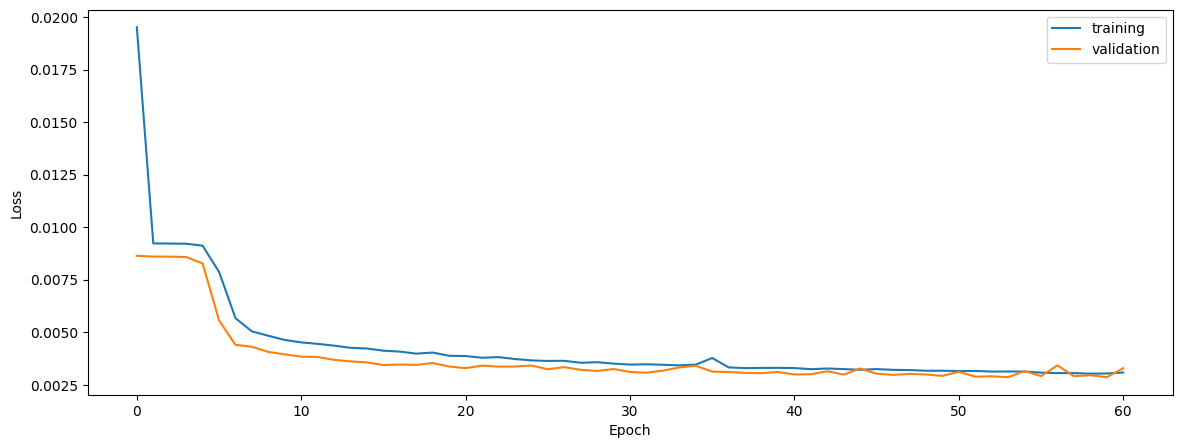

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8193129147045474
0.8171245851113726
0.7980821601183776


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.8193129147045474
0.8171245851113726
0.7980821601183776


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.8181907091082422
0.8174857904771838
0.7964116733537399


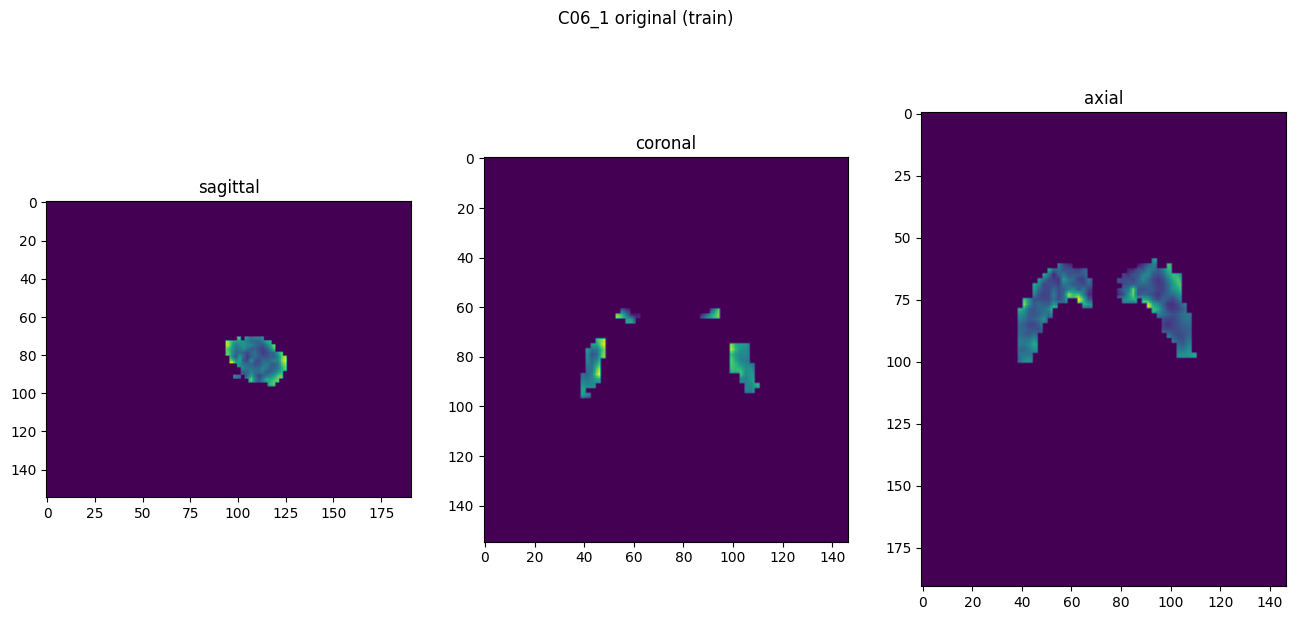

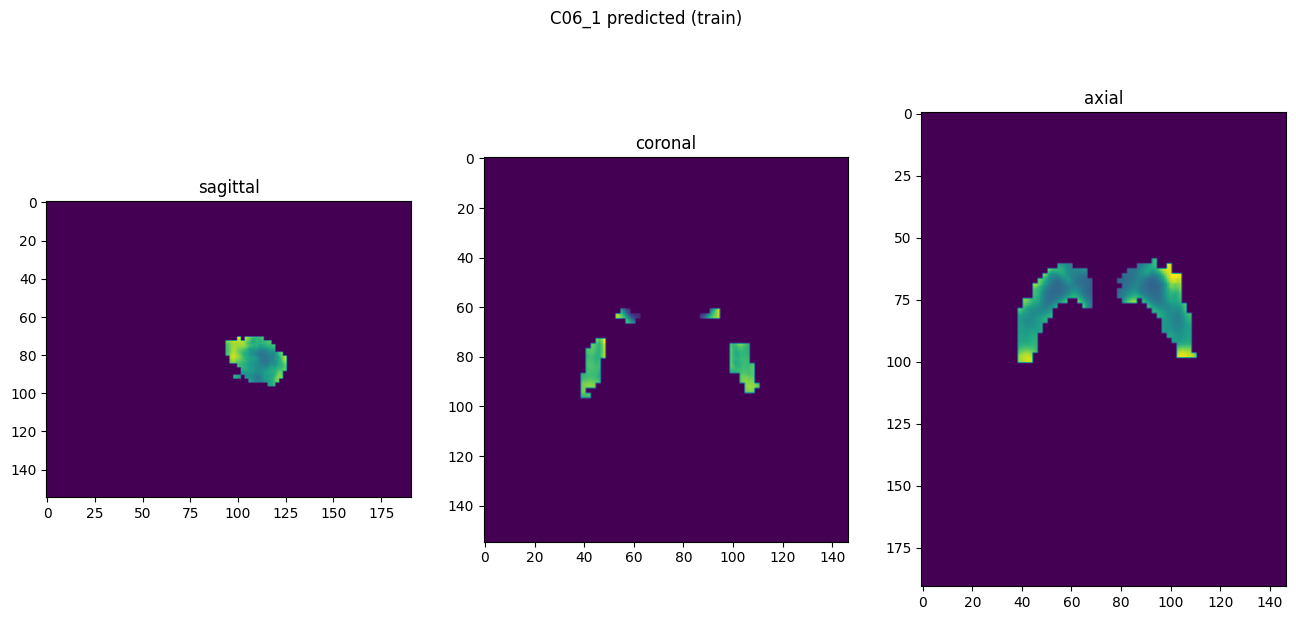

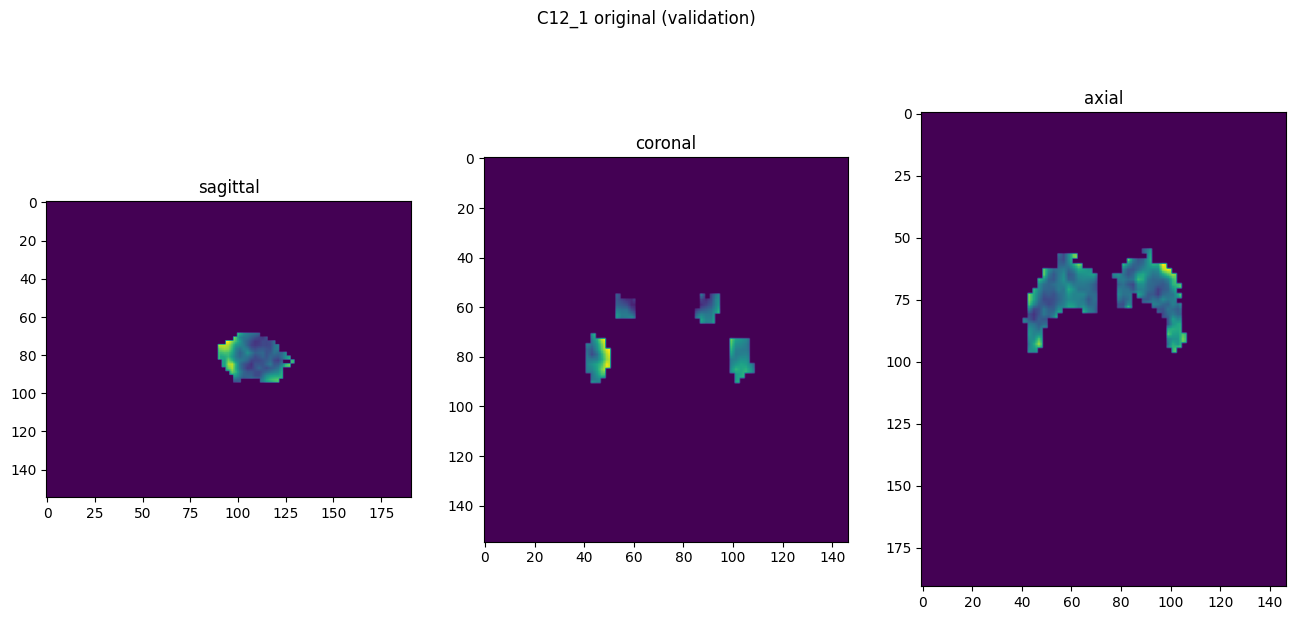

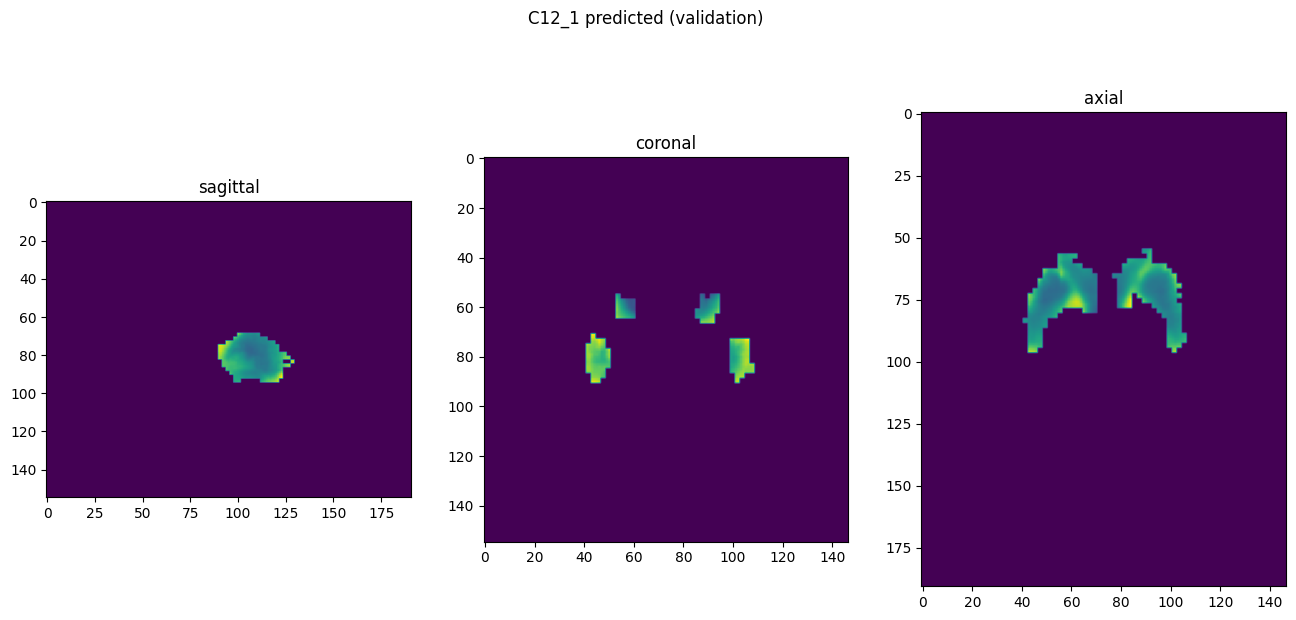

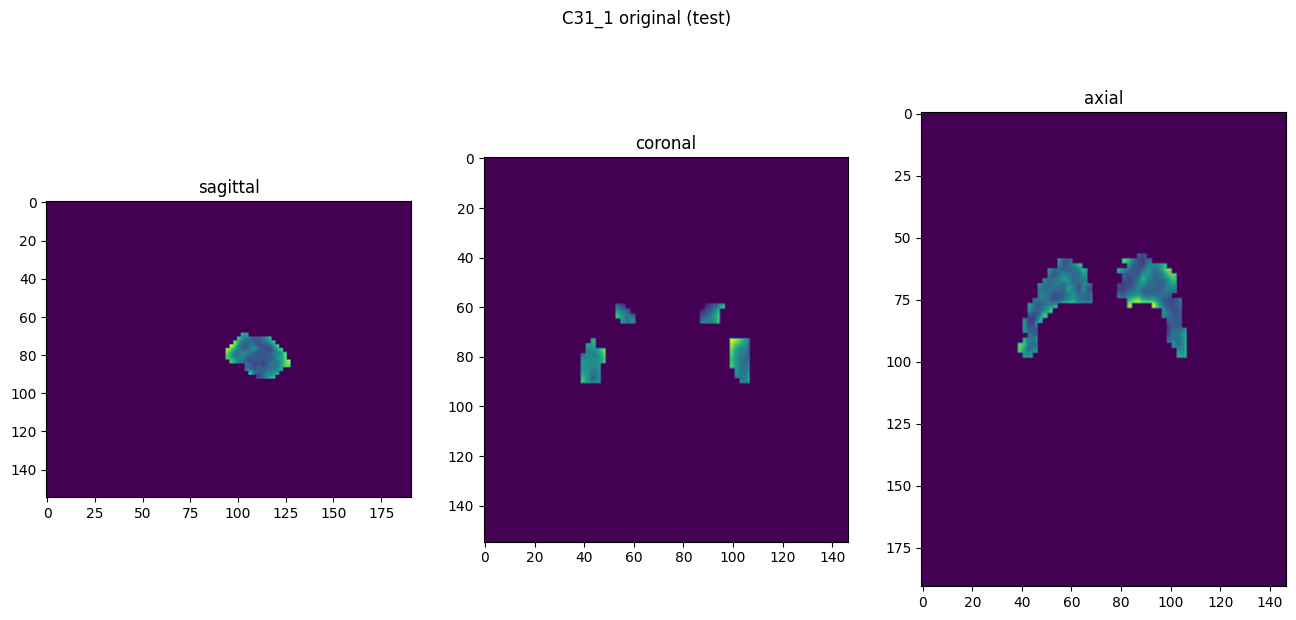

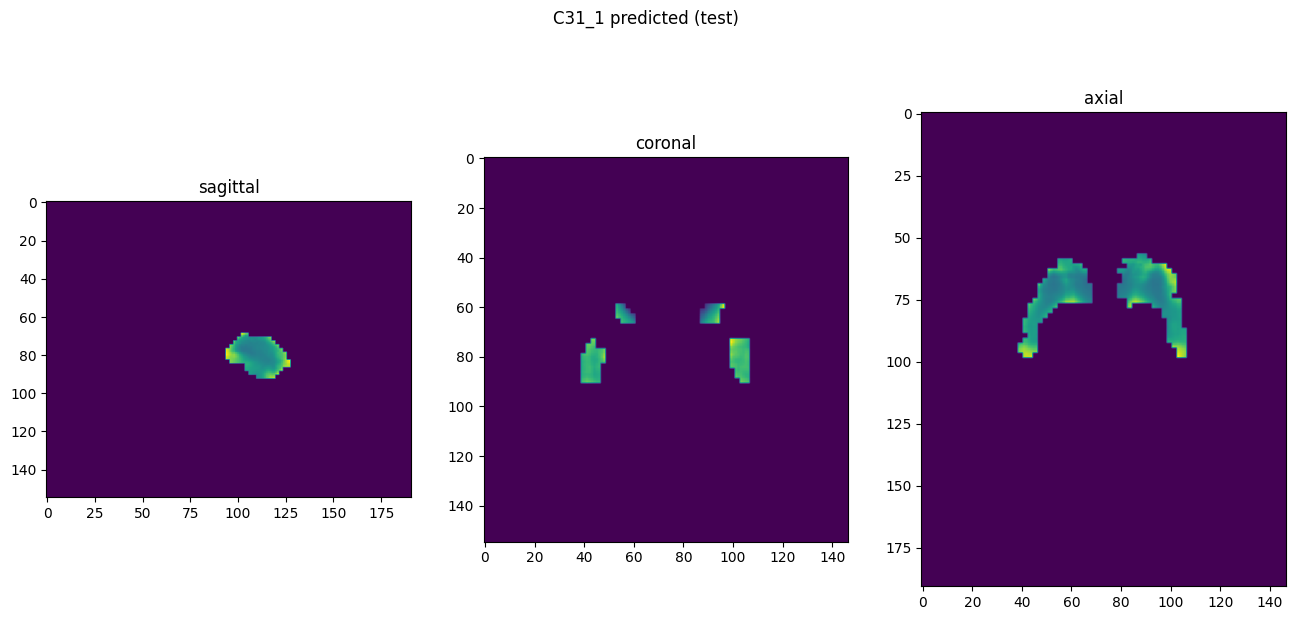

In [10]:
showResults(model, gen, threshold=None, background=False)